<a href="https://colab.research.google.com/github/Arazahari/NLP_Project/blob/main/Text_mining.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import requests
import pandas as pd
from bs4 import BeautifulSoup
import time
import nltk
from nltk.sentiment.vader import SentimentIntensityAnalyzer
import re
import matplotlib.pyplot as plt

In [ ]:
def get_comments(game_id, pages=2, delay=5):
    all_comments = []
    for p in range(1, pages+1):
        url = f"https://boardgamegeek.com/xmlapi2/thing?id={game_id}&comments=1&page={p}"
        r = requests.get(url)
        while r.status_code != 200:
            time.sleep(delay)
            r = requests.get(url)
        soup = BeautifulSoup(r.text, "xml")
        for c in soup.find_all('comment'):
            all_comments.append(c['value'])
        time.sleep(delay)
    return all_comments

# Fetch more comments per game (e.g. 20 pages instead of 2)
games = {
    "Gloomhaven": 174430,
    "Catan": 13,
    "Terraforming Mars": 167791,
    "7 Wonders": 68448,
    "Dominion": 36218,
    "Pandemic": 30549,
    "Wingspan": 266192,
    "Azul": 230802,
    "Brass Birmingham": 224517,
    "Scythe": 169786
}

rows = []
for name, gid in games.items():
    print(f"Fetching comments for {name}...")
    comments = get_comments(gid, pages=20, delay=2)  # fetch 20 pages per game
    for text in comments:
        rows.append({"game": name, "comment": text})

df = pd.DataFrame(rows)
df.to_csv("bgg_comments_api_large.csv", index=False)
print(f"✅ Saved {len(df)} comments across {len(games)} games.")



Fetching comments for Gloomhaven...
Fetching comments for Catan...
Fetching comments for Terraforming Mars...
Fetching comments for 7 Wonders...
Fetching comments for Dominion...
Fetching comments for Pandemic...
Fetching comments for Wingspan...
Fetching comments for Azul...
Fetching comments for Brass Birmingham...
Fetching comments for Scythe...
✅ Saved 20000 comments across 10 games.


In [ ]:
nltk.download('vader_lexicon')
sia = SentimentIntensityAnalyzer()

[nltk_data] Downloading package vader_lexicon to /root/nltk_data...


In [ ]:
df = pd.DataFrame(rows)
df.to_csv("bgg_comments_api_large.csv", index=False)
print(f"✅ Saved {len(df)} comments across {len(games)} games.")


✅ Saved 20000 comments across 10 games.


In [ ]:
df.head()

,game,comment
0,Gloomhaven,[thing=226868][/thing]
1,Gloomhaven,"1*,2*,3**,4** players 90-150 minutes Cooperative"
2,Gloomhaven,Need to sell.
3,Gloomhaven,Kickstarter Project http://kck.st/2nFXXlj - Ba...
4,Gloomhaven,1-4 players Best with 4


In [ ]:
def clean(text):
    text = str(text).lower()
    text = re.sub(r'[^\w\s]', '', text)
    return text

df['clean_comment'] = df['comment'].apply(clean)

In [ ]:
aspect_keywords = {
    "luck": ["luck", "random", "dice", "roll", "chance", "draw", "rng"],
    "bookkeeping": ["bookkeeping", "record", "tracking", "calculate", "math", "counting", "accounting", "scoring", "tally"],
    "downtime": ["downtime", "waiting", "wait", "idle", "nothing to do", "slow", "pause", "boring turn"],
    "interaction": ["interaction", "player", "opponent", "conflict", "attack", "competition", "multiplayer", "cooperation"],
    "bash_the_leader": ["bash the leader", "gang up", "kingmaking", "take down", "target leader", "everyone attacks", "leader bashing"],
    "complexity": ["complex", "deep", "strategic", "strategy", "depth"],
    "complicated": ["complicated", "confusing", "hard to learn", "many rules", "rulebook", "exceptions", "fiddly"]
}


In [ ]:
def detect_aspects(text):
    matched = []
    for aspect, keywords in aspect_keywords.items():
        if any(word in text for word in keywords):
            matched.append(aspect)
    return matched if matched else ["none"]


df['aspects'] = df['clean_comment'].apply(detect_aspects)

In [ ]:
def get_sentiment(text):
    score = sia.polarity_scores(text)['compound']
    if score >= 0.05:
        return "positive"
    elif score <= -0.05:
        return "negative"
    else:
        return "neutral"

df['sentiment'] = df['clean_comment'].apply(get_sentiment)

In [ ]:
df_exploded = df.explode('aspects')
df_filtered = df_exploded[df_exploded['aspects'] != "none"]

In [ ]:
df_filtered.to_csv("aspect_sentiment_results.csv", index=False)
print("✅ Saved aspect-level sentiment results to 'aspect_sentiment_results.csv'")

✅ Saved aspect-level sentiment results to 'aspect_sentiment_results.csv'


In [ ]:
df = pd.read_csv("aspect_sentiment_results.csv")

aspects            bash_the_leader  bookkeeping  complexity  complicated  \
game                                                                       
7 Wonders                        0           17          43            2   
Azul                             1           16          36            2   
Brass Birmingham                 1           11          67           28   
Catan                            0           16          33            2   
Dominion                         0           12          44            3   
Gloomhaven                       0            9          34           13   
Pandemic                         0           15          22            2   
Scythe                           0            3          53           22   
Terraforming Mars                0            9          39           10   
Wingspan                         0            6          34            4   

aspects            downtime  interaction  luck  
game                                  

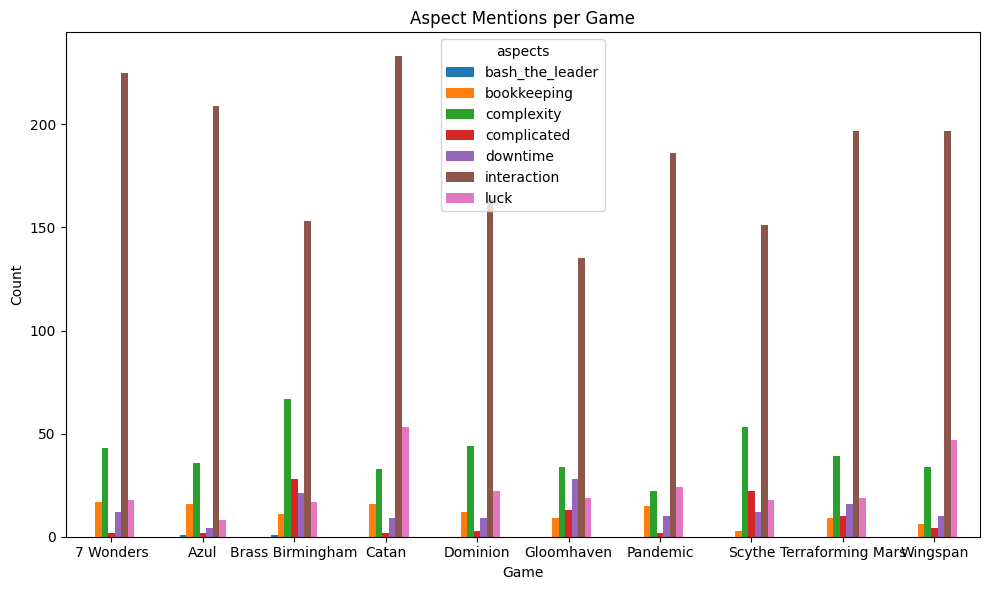

In [ ]:
# Count how often each aspect is mentioned per game
aspect_counts_by_game = df_filtered.groupby(["game", "aspects"]).size().unstack(fill_value=0)

print(aspect_counts_by_game)

# Plot
aspect_counts_by_game.plot(kind="bar", figsize=(10,6))
plt.title("Aspect Mentions per Game")
plt.ylabel("Count")
plt.xlabel("Game")
plt.xticks(rotation=0)
plt.tight_layout()
plt.savefig("plot_aspect_mentions_per_game.png")
plt.show()


sentiment              negative  neutral  positive
game      aspects                                 
7 Wonders bookkeeping         2        6         9
          complexity          1       17        25
          complicated         0        0         2
          downtime            1        2         9
          interaction         7      106       112
...                         ...      ...       ...
Wingspan  complexity          2       12        20
          complicated         1        0         3
          downtime            1        1         8
          interaction         5      111        81
          luck                3        9        35

[62 rows x 3 columns]


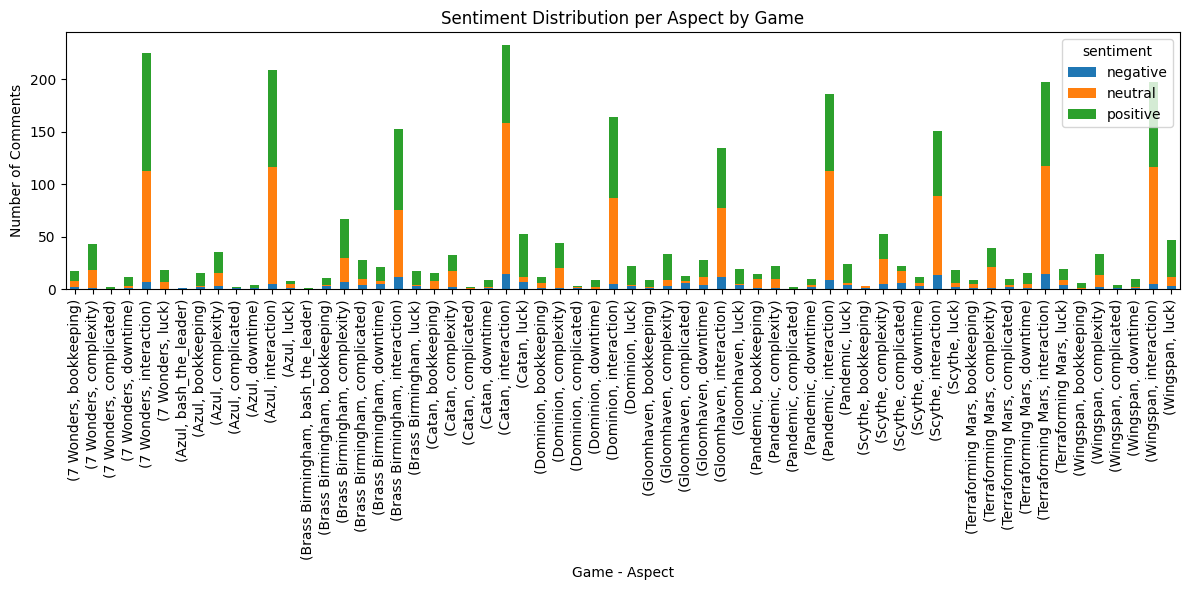

In [ ]:
# Group by game, aspect, and sentiment
game_aspect_sentiment = df_filtered.groupby(["game", "aspects", "sentiment"]).size().unstack(fill_value=0)

print(game_aspect_sentiment)

# Plot
game_aspect_sentiment.plot(kind="bar", stacked=True, figsize=(12,6))
plt.title("Sentiment Distribution per Aspect by Game")
plt.ylabel("Number of Comments")
plt.xlabel("Game - Aspect")
plt.xticks(rotation=90)
plt.tight_layout()
plt.savefig("plot_sentiment_per_aspect_game.png")
plt.show()


In [ ]:
from collections import Counter
from nltk.corpus import stopwords

# Download stopwords if not already
nltk.download('stopwords')
stop_words = set(stopwords.words("english"))

def tokenize(text):
    words = text.split()
    words = [w for w in words if w not in stop_words and len(w) > 2]  # remove stopwords & very short words
    return words

df_filtered['tokens'] = df_filtered['clean_comment'].apply(tokenize)


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
/tmp/ipython-input-3288724367.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_filtered['tokens'] = df_filtered['clean_comment'].apply(tokenize)


In [ ]:
def top_words(aspect, sentiment, n=10):
    # Filter by aspect & sentiment
    subset = df_filtered[(df_filtered['aspects'] == aspect) & (df_filtered['sentiment'] == sentiment)]
    # Flatten all tokens
    all_words = [w for tokens in subset['tokens'] for w in tokens]
    # Count most common
    return Counter(all_words).most_common(n)

# Example: top 10 words in negative comments about luck
print(top_words("luck", "negative", 10))


[('cards', 33), ('game', 32), ('player', 14), ('dont', 12), ('dice', 11), ('random', 11), ('players', 9), ('games', 9), ('way', 7), ('scenario', 7)]


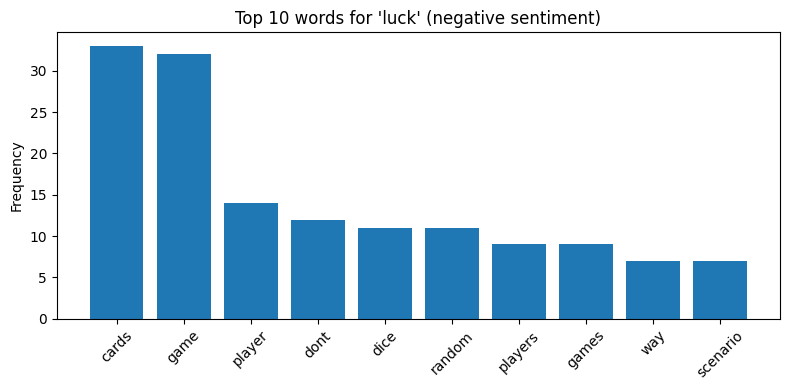

In [ ]:
def plot_top_words(aspect, sentiment, n=10):
    words = top_words(aspect, sentiment, n)
    if not words:
        print(f"No words found for {aspect} - {sentiment}")
        return
    labels, counts = zip(*words)
    plt.figure(figsize=(8,4))
    plt.bar(labels, counts)
    plt.title(f"Top {n} words for '{aspect}' ({sentiment} sentiment)")
    plt.ylabel("Frequency")
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

# Example: plot top words for "luck" negative comments
plot_top_words("luck", "negative")
